In [1]:
!pip install ultralytics
import ultralytics
ultralytics.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 45.8 MB/s eta 0:00:00


'8.2.87'

In [2]:
import torch
torch.__version__

'2.4.0+cu121'

In [3]:
from ultralytics import YOLO

import time
import torch
import cv2
import torch.backends.cudnn as cudnn
from PIL import Image
import colorsys
import numpy as np

# Load a model
model = YOLO("/content/best.pt")

In [4]:
results = model("/content/image.jpg", save=True)


image 1/1 /content/image.jpg: 448x640 1 Adult, 1 Child, 36.0ms
Speed: 11.1ms preprocess, 36.0ms inference, 716.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/78.2 GB disk)


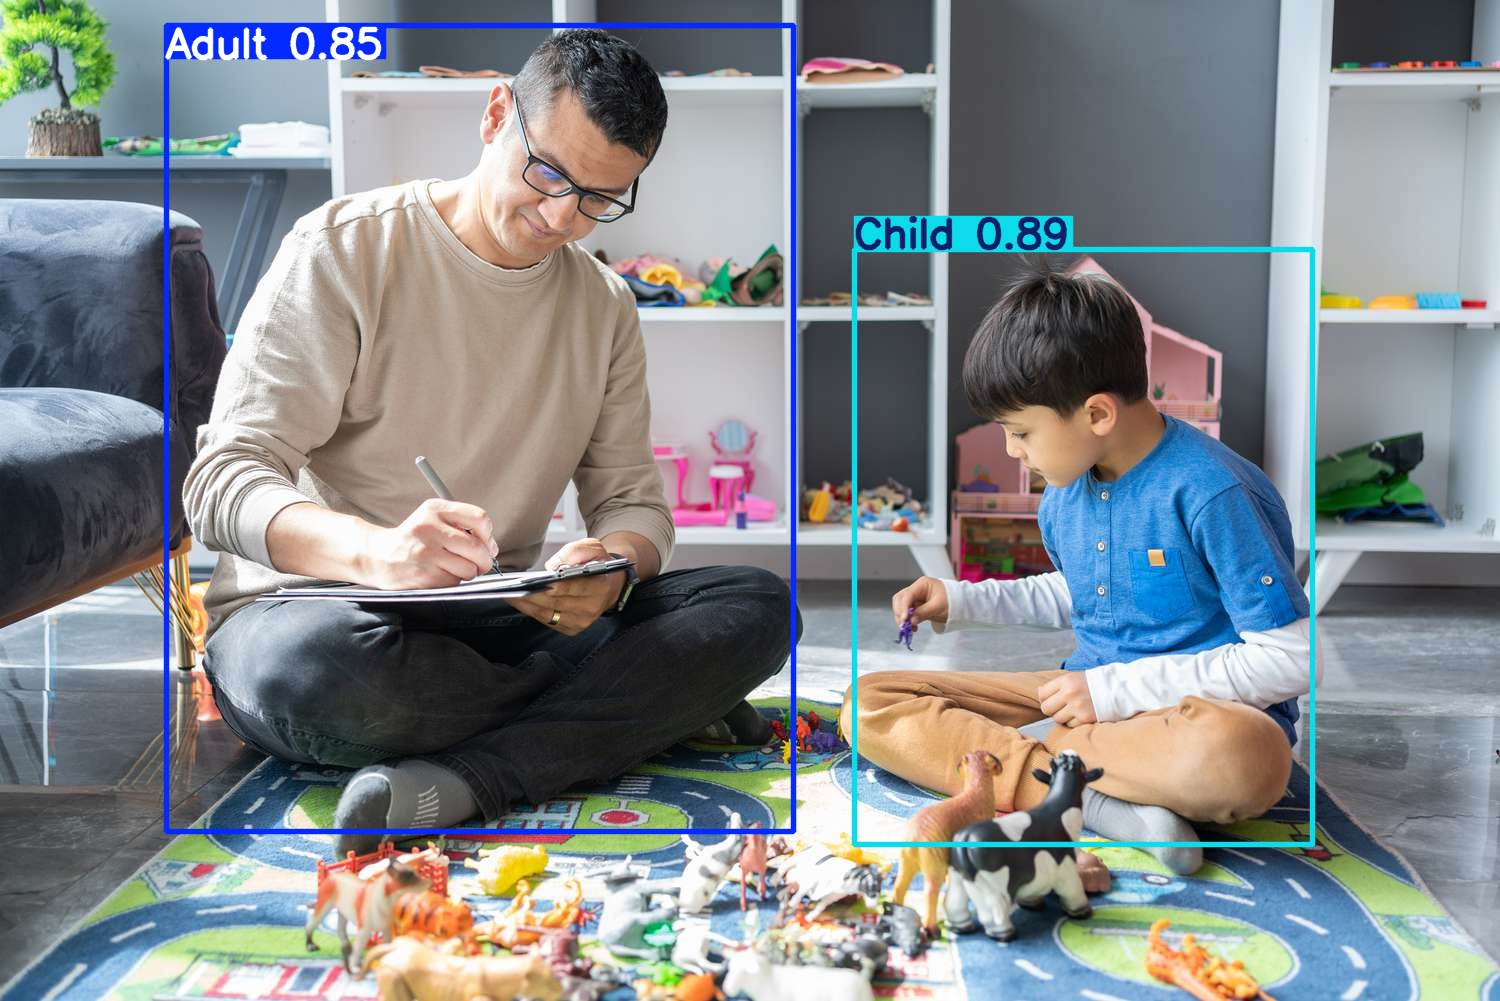

In [5]:
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from IPython.display import display, Image
Image('/content/runs/detect/predict/image.jpg',width=600)

In [6]:
!pip install torch torchvision torchaudio
!pip install ultralytics
!pip install deep_sort_realtime
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 89.3 MB/s eta 0:00:00


In [7]:
from deep_sort_realtime.deepsort_tracker import DeepSort
import os

In [ ]:
# List of video files to process
input_video_folder = "/content/input_videos"
video_files = [os.path.join(input_video_folder, file) for file in os.listdir(input_video_folder) if file.endswith(".mp4")] # Replace with your video file paths

# Directory to save output videos
output_dir = "output_videos"
os.makedirs(output_dir, exist_ok=True)

# Define colors for children and adults
child_color = (0, 255, 255)
adult_color = (255, 0, 0)

for video_file in video_files:
    # Create DeepSort object for tracking
    deepsort = DeepSort(max_age=150, n_init=3, nms_max_overlap=0.8, max_iou_distance=0.7)

    # Open the video file
    cap = cv2.VideoCapture(video_file)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(os.path.join(output_dir, os.path.basename(video_file)), fourcc, fps, (width, height))

    # Create a dictionary to store the class ID and track ID association
    track_classes = {}
    child_ids = set()
    adult_ids = set()
    next_child_id = 1
    next_adult_id = 100

    # Process video frames
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Run detection with YOLOv8
        results = model(frame)  # Perform inference

        # Extract bounding boxes, confidences, and class IDs
        detections = []
        for box in results[0].boxes:  # Iterate through detected objects
            bbox = box.xyxy[0].cpu().numpy()  # Bounding box coordinates in xyxy format
            confidence = box.conf.cpu().numpy()  # Confidence score
            class_id = box.cls.cpu().numpy()  # Class ID
            detections.append((bbox, confidence, class_id))

        # Update tracker
        tracks = deepsort.update_tracks(detections, frame=frame)

        # Draw bounding boxes and IDs on the output frame
        for track in tracks:
            if track.is_confirmed() and track.time_since_update <= 1:
                bbox = track.to_tlbr()  # Bounding box coordinates
                track_id = str(track.track_id)  # Track ID

                # Associate class ID with track ID when the track is first detected
                if track_id not in track_classes:
                    class_id = None
                    for detection in detections:
                        if detection[0][0] < bbox[2] and detection[0][2] > bbox[0] and detection[0][1] < bbox[3] and detection[0][3] > bbox[1]:
                            class_id = detection[2]
                            break
                    if class_id == 1:  # Child
                        track_id = next_child_id
                        child_ids.add(track_id)
                        next_child_id += 1
                    elif class_id ==0:  # Adult
                        track_id = next_adult_id
                        adult_ids.add(track_id)
                        next_adult_id += 1
                    track_classes[track_id] = class_id
                else:
                    class_id = track_classes[track_id]

                # Classify as child or adult based on the class ID
                if class_id == 1:
                    color = child_color
                    class_label = "Child"
                elif class_id == 0:
                    color = adult_color
                    class_label = "therapist"

                # Draw bounding box
                cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
                # Draw track ID and class label
                cv2.putText(frame, f"ID {track_id} - {class_label}", (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)

        # Remove inactive tracks
        for track_id in list(track_classes.keys()):
            if track_id not in [track.track_id for track in tracks]:
                if track_id in child_ids:
                    if track_id in child_ids:  # Check if track_id exists in child_ids
                        child_ids.remove(track_id)
                    next_child_id -= 1
                elif track_id in adult_ids:  # Check if track_id exists in adult_ids
                    adult_ids.remove(track_id)
                    next_adult_id -= 1
                del track_classes[track_id]

        # Write output frame to file
        out.write(frame)

    # Release video capture and writer
    cap.release()
    out.release()

Streaming output truncated to the last 5000 lines.
0: 384x640 1 Adult, 1 Child, 15.3ms
Speed: 3.8ms preprocess, 15.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Adult, 1 Child, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Adult, 1 Child, 8.5ms
Speed: 6.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Adults, 1 Child, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Adults, 1 Child, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Adults, 1 Child, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Adults, 1 Child, 12.6ms
Speed: 5.4ms preprocess, 12.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Ad